<a href="https://colab.research.google.com/github/Waranika/DCU-EE514-DA-ML/blob/main/Assignement/Assignement_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
path = "/content/drive/MyDrive/The ExtraSensory Dataset/ExtraSensory.per_uuid_features_labels"

In [3]:
files = [f for f in os.listdir(path) if f.endswith('.gz')]
print(files)

['A5A30F76-581E-4757-97A2-957553A2C6AA.features_labels.csv.gz', 'BEF6C611-50DA-4971-A040-87FB979F3FC1.features_labels.csv.gz', '098A72A5-E3E5-4F54-A152-BBDA0DF7B694.features_labels.csv.gz', 'D7D20E2E-FC78-405D-B346-DBD3FD8FC92B.features_labels.csv.gz', '2C32C23E-E30C-498A-8DD2-0EFB9150A02E.features_labels.csv.gz', '136562B6-95B2-483D-88DC-065F28409FD2.features_labels.csv.gz', '11B5EC4D-4133-4289-B475-4E737182A406.features_labels.csv.gz', '4FC32141-E888-4BFF-8804-12559A491D8C.features_labels.csv.gz', '86A4F379-B305-473D-9D83-FC7D800180EF.features_labels.csv.gz', 'CA820D43-E5E2-42EF-9798-BE56F776370B.features_labels.csv.gz', 'A5CDF89D-02A2-4EC1-89F8-F534FDABDD96.features_labels.csv.gz', 'B7F9D634-263E-4A97-87F9-6FFB4DDCB36C.features_labels.csv.gz', '1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842.features_labels.csv.gz', '74B86067-5D4B-43CF-82CF-341B76BEA0F4.features_labels.csv.gz', '33A85C34-CFE4-4732-9E73-0A7AC861B27A.features_labels.csv.gz', '9759096F-1119-4E19-A0AD-6F16989C7E1C.features_labels.

In [4]:
df = pd.DataFrame()
# Loop through each .gz file, unzip, and append to the DataFrame
for gz_file in files:
    with gzip.open(os.path.join(path, gz_file), 'rt') as f:
        # Assuming the CSV file inside the .gz is comma-separated, adjust delimiter if needed
        data = pd.read_csv(f, delimiter=',')
        df = pd.concat([df, data], ignore_index=True)

In [5]:
print(df)

         timestamp  raw_acc:magnitude_stats:mean  raw_acc:magnitude_stats:std  \
0       1437680357                      1.000726                     0.002890   
1       1437680405                      1.001435                     0.002014   
2       1437680465                      1.001515                     0.003096   
3       1437680526                      1.000972                     0.001954   
4       1437680616                      1.001143                     0.025751   
...            ...                           ...                          ...   
377341  1464895317                      1.000707                     0.050293   
377342  1464895378                      0.996989                     0.007465   
377343  1464895455                      0.996782                     0.011491   
377344  1464895515                      0.995879                     0.002902   
377345  1464895575                      0.994668                     0.002042   

        raw_acc:magnitude_s

*DATA REPRESENTATION*

In [6]:
df.describe()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
count,3.773460e+05,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,...,94415.000000,71196.000000,306594.000000,259164.000000,141703.000000,92462.000000,162423.000000,112064.000000,165414.000000,377346.000000
mean,1.445839e+09,1.002223,0.038832,0.037772,0.072804,0.983165,0.998471,1.016691,2.045331,6.680278,...,0.008198,0.002809,0.123231,0.163337,0.102842,0.110326,0.708256,0.055540,0.149546,1.565261
std,5.907009e+06,0.079623,0.096109,0.113198,0.170481,0.082960,0.076687,0.104874,0.616899,0.021246,...,0.090171,0.052927,0.328703,0.369673,0.303753,0.313298,0.454567,0.229032,0.356627,1.463029
min,1.433537e+09,0.018148,0.000030,-0.493806,0.000039,0.015845,0.017998,0.020365,0.009605,5.460637,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,1.441438e+09,0.992556,0.001709,-0.000785,0.002328,0.982671,0.991248,0.994859,1.671571,6.684369,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,1.444974e+09,1.001258,0.003265,0.000772,0.005051,0.995300,1.000116,1.003813,2.296398,6.684606,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
75%,1.448696e+09,1.012745,0.021366,0.009864,0.045333,1.003679,1.009232,1.019163,2.523618,6.684610,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000
max,1.464899e+09,3.185837,1.936343,2.472750,3.360718,1.942718,2.636697,3.958338,2.971272,6.684612,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [7]:
# Extracting columns starting with 'proc' or 'raw'
raw_data_readings = df.filter(regex='^(proc|raw)')

# Describing the selected columns
raw_data_readings.describe()


,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,...,raw_magnet:3d:std_y,raw_magnet:3d:std_z,raw_magnet:3d:ro_xy,raw_magnet:3d:ro_xz,raw_magnet:3d:ro_yz,raw_magnet:avr_cosine_similarity_lag_range0,raw_magnet:avr_cosine_similarity_lag_range1,raw_magnet:avr_cosine_similarity_lag_range2,raw_magnet:avr_cosine_similarity_lag_range3,raw_magnet:avr_cosine_similarity_lag_range4
count,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,377056.000000,...,346025.000000,346025.000000,345149.000000,345575.000000,345449.000000,346025.000000,346025.000000,346025.000000,346025.000000,346025.000000
mean,1.002223,0.038832,0.037772,0.072804,0.983165,0.998471,1.016691,2.045331,6.680278,5.039597,...,2.662531,2.904427,0.016559,0.011607,-0.003313,0.999449,0.999121,0.998286,0.996813,0.986172
std,0.079623,0.096109,0.113198,0.170481,0.082960,0.076687,0.104874,0.616899,0.021246,0.025809,...,11.445300,11.780716,0.390024,0.398956,0.387409,0.015529,0.016046,0.018115,0.033389,0.105407
min,0.018148,0.000030,-0.493806,0.000039,0.015845,0.017998,0.020365,0.009605,5.460637,4.338109,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-0.320454,-0.905040,-0.948784
25%,0.992556,0.001709,-0.000785,0.002328,0.982671,0.991248,0.994859,1.671571,6.684369,5.042891,...,0.737282,0.731671,-0.074774,-0.132440,-0.100137,0.999936,0.999888,0.999844,0.999809,0.999750
50%,1.001258,0.003265,0.000772,0.005051,0.995300,1.000116,1.003813,2.296398,6.684606,5.043350,...,0.785152,0.802989,0.005513,-0.020600,-0.003247,0.999990,0.999986,0.999984,0.999982,0.999980
75%,1.012745,0.021366,0.009864,0.045333,1.003679,1.009232,1.019163,2.523618,6.684610,5.043574,...,1.627928,1.726690,0.103366,0.099251,0.080320,0.999996,0.999995,0.999995,0.999995,0.999995
max,3.185837,1.936343,2.472750,3.360718,1.942718,2.636697,3.958338,2.971272,6.684612,6.489025,...,2176.581348,1744.604115,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Extracting columns starting with 'proc' or 'raw'
raw_watch_readings = df.filter(like='watch')

# Describing the selected columns
raw_watch_readings.describe()

,watch_acceleration:magnitude_stats:mean,watch_acceleration:magnitude_stats:std,watch_acceleration:magnitude_stats:moment3,watch_acceleration:magnitude_stats:moment4,watch_acceleration:magnitude_stats:percentile25,watch_acceleration:magnitude_stats:percentile50,watch_acceleration:magnitude_stats:percentile75,watch_acceleration:magnitude_stats:value_entropy,watch_acceleration:magnitude_stats:time_entropy,watch_acceleration:magnitude_spectrum:log_energy_band0,...,watch_acceleration:relative_directions:avr_cosine_similarity_lag_range4,watch_heading:mean_cos,watch_heading:std_cos,watch_heading:mom3_cos,watch_heading:mom4_cos,watch_heading:mean_sin,watch_heading:std_sin,watch_heading:mom3_sin,watch_heading:mom4_sin,watch_heading:entropy_8bins
count,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,244802.000000,...,244802.000000,147415.000000,147415.000000,147415.000000,147415.000000,147415.000000,147415.000000,147415.000000,147415.000000,147415.000000
mean,1028.890233,65.731225,54.667315,122.592605,998.783850,1023.673423,1052.407856,1.997444,5.910505,5.021269,...,0.797822,-0.025359,0.302725,0.003126,0.392300,-0.015159,0.287672,0.006082,0.373939,0.765980
std,49.106854,91.525328,125.109478,174.731291,39.357481,39.913269,85.110513,0.490164,0.414305,0.346167,...,0.324213,0.582469,0.266041,0.359798,0.325597,0.590086,0.257848,0.343698,0.316107,0.648247
min,880.184417,2.935715,-535.244867,3.987740,428.634690,819.912190,941.080230,0.014427,2.962748,0.000000,...,-0.974939,-0.999895,0.000076,-0.914928,0.000076,-0.999878,0.000000,-0.914815,0.000000,-0.000000
25%,1006.345562,13.236651,-6.337331,19.744464,985.673373,1004.597432,1015.653484,1.734896,5.777048,5.042606,...,0.706914,-0.513068,0.027293,-0.222469,0.037471,-0.520331,0.029196,-0.191700,0.039120,-0.000000
50%,1022.198931,21.722183,8.367984,36.034501,1000.831654,1018.924924,1033.804597,2.134219,6.100122,5.045679,...,0.981081,-0.030001,0.265439,0.001584,0.385268,-0.031349,0.237999,0.001560,0.346446,0.713510
75%,1039.027288,85.678335,73.436227,164.121720,1016.527281,1034.353905,1058.179533,2.343302,6.213958,5.049228,...,0.999717,0.459541,0.538895,0.230924,0.708518,0.489492,0.514285,0.221637,0.683331,1.331647
max,2500.947775,1505.690106,1741.172696,2154.495365,2098.761540,2357.225259,3357.256601,2.963879,6.214595,6.009607,...,0.999983,0.999927,0.998065,0.914136,1.072989,0.999921,0.994814,0.915049,1.073294,2.071655


In [9]:
missing_values_raw_data = raw_data_readings.isnull().sum()
missing_values_raw_watch = raw_watch_readings.isnull().sum()
print(missing_values_raw_data)
print(missing_values_raw_watch)

raw_acc:magnitude_stats:mean                     290
raw_acc:magnitude_stats:std                      290
raw_acc:magnitude_stats:moment3                  290
raw_acc:magnitude_stats:moment4                  290
raw_acc:magnitude_stats:percentile25             290
                                               ...  
raw_magnet:avr_cosine_similarity_lag_range0    31321
raw_magnet:avr_cosine_similarity_lag_range1    31321
raw_magnet:avr_cosine_similarity_lag_range2    31321
raw_magnet:avr_cosine_similarity_lag_range3    31321
raw_magnet:avr_cosine_similarity_lag_range4    31321
Length: 83, dtype: int64
watch_acceleration:magnitude_stats:mean                                    132544
watch_acceleration:magnitude_stats:std                                     132544
watch_acceleration:magnitude_stats:moment3                                 132544
watch_acceleration:magnitude_stats:moment4                                 132544
watch_acceleration:magnitude_stats:percentile25                 

Overall Average Missing Values in raw_data_readings: 0.045947955214667
Overall Average Missing Values in raw_watch_readings: 0.3934851689045453


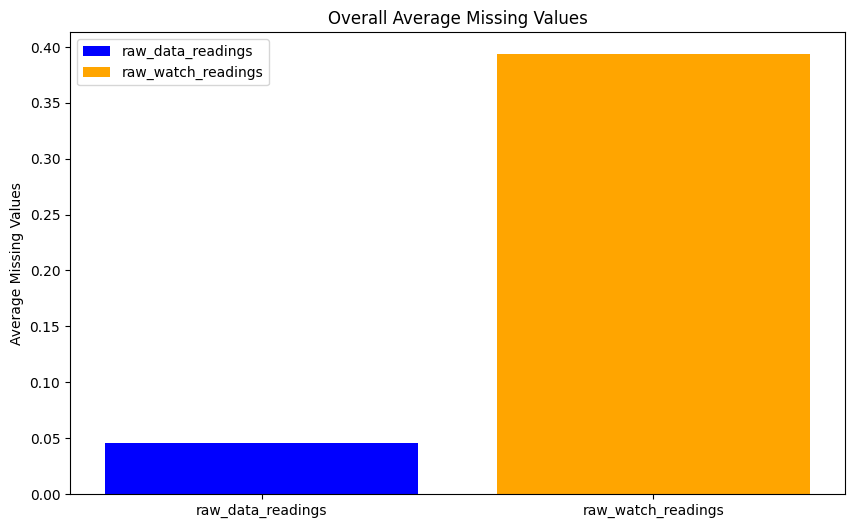

In [10]:
# Calculate the overall average of missing values for each DataFrame
overall_average_missing_raw_data = raw_data_readings.isnull().mean().mean()
overall_average_missing_raw_watch = raw_watch_readings.isnull().mean().mean()

# Print the overall average missing values for each DataFrame
print("Overall Average Missing Values in raw_data_readings:", overall_average_missing_raw_data)
print("Overall Average Missing Values in raw_watch_readings:", overall_average_missing_raw_watch)

# Plotting the overall average missing values for each DataFrame
plt.figure(figsize=(10, 6))

# Plot for raw_data_readings
plt.bar("raw_data_readings", overall_average_missing_raw_data, color="blue", label="raw_data_readings")

# Plot for raw_watch_readings
plt.bar("raw_watch_readings", overall_average_missing_raw_watch, color="orange", label="raw_watch_readings")

plt.title('Overall Average Missing Values')
plt.ylabel('Average Missing Values')
plt.legend()
plt.show()

In [11]:
watch_columns = df.filter(like="watch")
print(watch_columns.sum())
df = df.drop(columns=watch_columns)
df.shape

watch_acceleration:magnitude_stats:mean                                    2.518744e+08
watch_acceleration:magnitude_stats:std                                     1.609114e+07
watch_acceleration:magnitude_stats:moment3                                 1.338267e+07
watch_acceleration:magnitude_stats:moment4                                 3.001091e+07
watch_acceleration:magnitude_stats:percentile25                            2.445043e+08
watch_acceleration:magnitude_stats:percentile50                            2.505973e+08
watch_acceleration:magnitude_stats:percentile75                            2.576315e+08
watch_acceleration:magnitude_stats:value_entropy                           4.889784e+05
watch_acceleration:magnitude_stats:time_entropy                            1.446903e+06
watch_acceleration:magnitude_spectrum:log_energy_band0                     1.229217e+06
watch_acceleration:magnitude_spectrum:log_energy_band1                     6.653512e+04
watch_acceleration:magnitude_spe

(377346, 223)

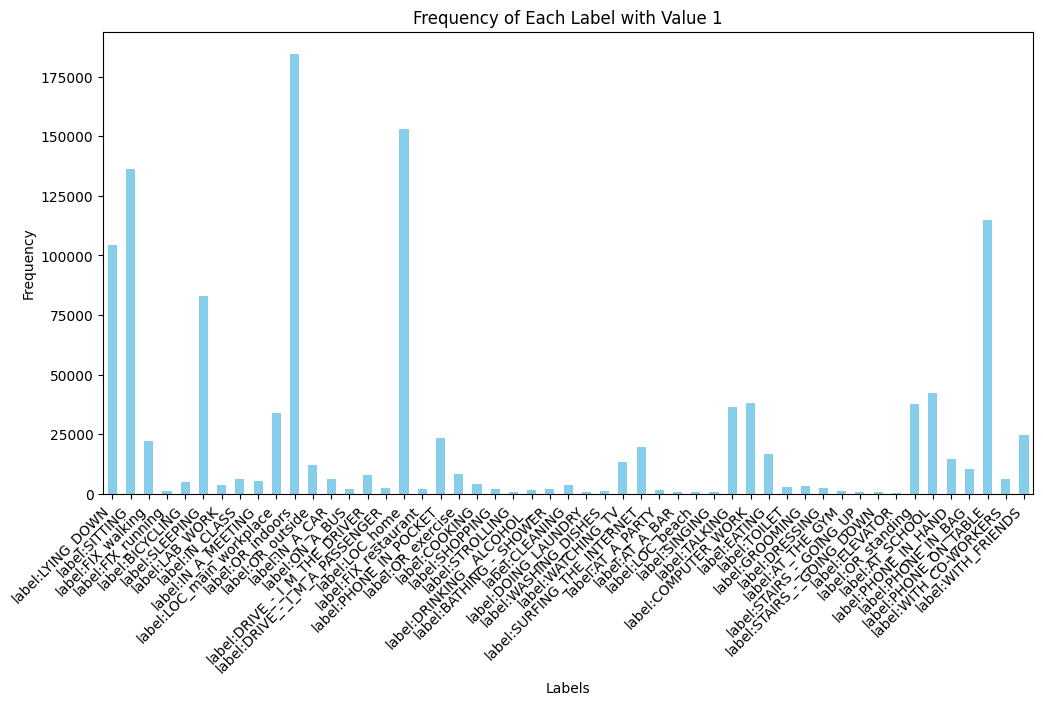

In [12]:
# Extracting only the 'label' columns
label_columns = df.filter(like='label:')


# Counting the occurrences of value 1 in each 'label' column
label_counts = label_columns.sum()

# Plotting the bar graph
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Label with Value 1')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

*PREPROCESSING*

Delete incomplete columns


In [13]:
count = 0
j = 0
for i in df.columns:
    if j > 225:
      break
    # Count the occurrences of 'na' in each column
    count = (df[i] == 'nan').sum()
    j = j+1
    # Check if the total count of 'na' values and NaN values exceeds a threshold
    if df[i].isnull().sum() + count > 377346*0.6 :
        # Delete the column if the condition is met
        print(i)
        print(df[i].isnull().sum() + count)
        del df[i]

location:min_speed
272817
location:max_speed
272817
lf_measurements:light
230314
lf_measurements:pressure
270151
lf_measurements:proximity_cm
228726
lf_measurements:relative_humidity
351407
lf_measurements:temperature_ambient
350896
label:FIX_running
236476
label:BICYCLING
242163
label:LAB_WORK
327951
label:IN_CLASS
268283
label:DRIVE_-_I_M_A_PASSENGER
246259
label:PHONE_IN_POCKET
242982
label:SHOPPING
238553
label:STROLLING
323585
label:DRINKING__ALCOHOL_
306563
label:DOING_LAUNDRY
303374
label:WASHING_DISHES
240872
label:AT_A_PARTY
322783
label:AT_A_BAR
344126
label:LOC_beach
319702
label:SINGING
352229
label:AT_THE_GYM
332953
label:STAIRS_-_GOING_UP
282717
label:STAIRS_-_GOING_DOWN
282931
label:ELEVATOR
306150
label:PHONE_IN_HAND
235643
label:PHONE_IN_BAG
284884
label:WITH_CO-WORKERS
265282


In [14]:
df.shape

(377346, 194)

Delete irrelevant columns for the analysis

In [15]:
del df['timestamp']
df.shape

(377346, 193)

Delete known biased columns that might wrong the prediction

Correlation Matrix:
                                             location:num_valid_updates  \
location:num_valid_updates                                     1.000000   
location:log_latitude_range                                    0.261537   
location:log_longitude_range                                   0.266808   
location:min_altitude                                         -0.021025   
location:max_altitude                                         -0.006527   
location:best_horizontal_accuracy                             -0.599665   
location:best_vertical_accuracy                               -0.526946   
location:diameter                                              0.181905   
location:log_diameter                                          0.559041   
location_quick_features:std_lat                               -0.005652   
location_quick_features:std_long                              -0.005079   
location_quick_features:lat_change                            -0.007431   
locat

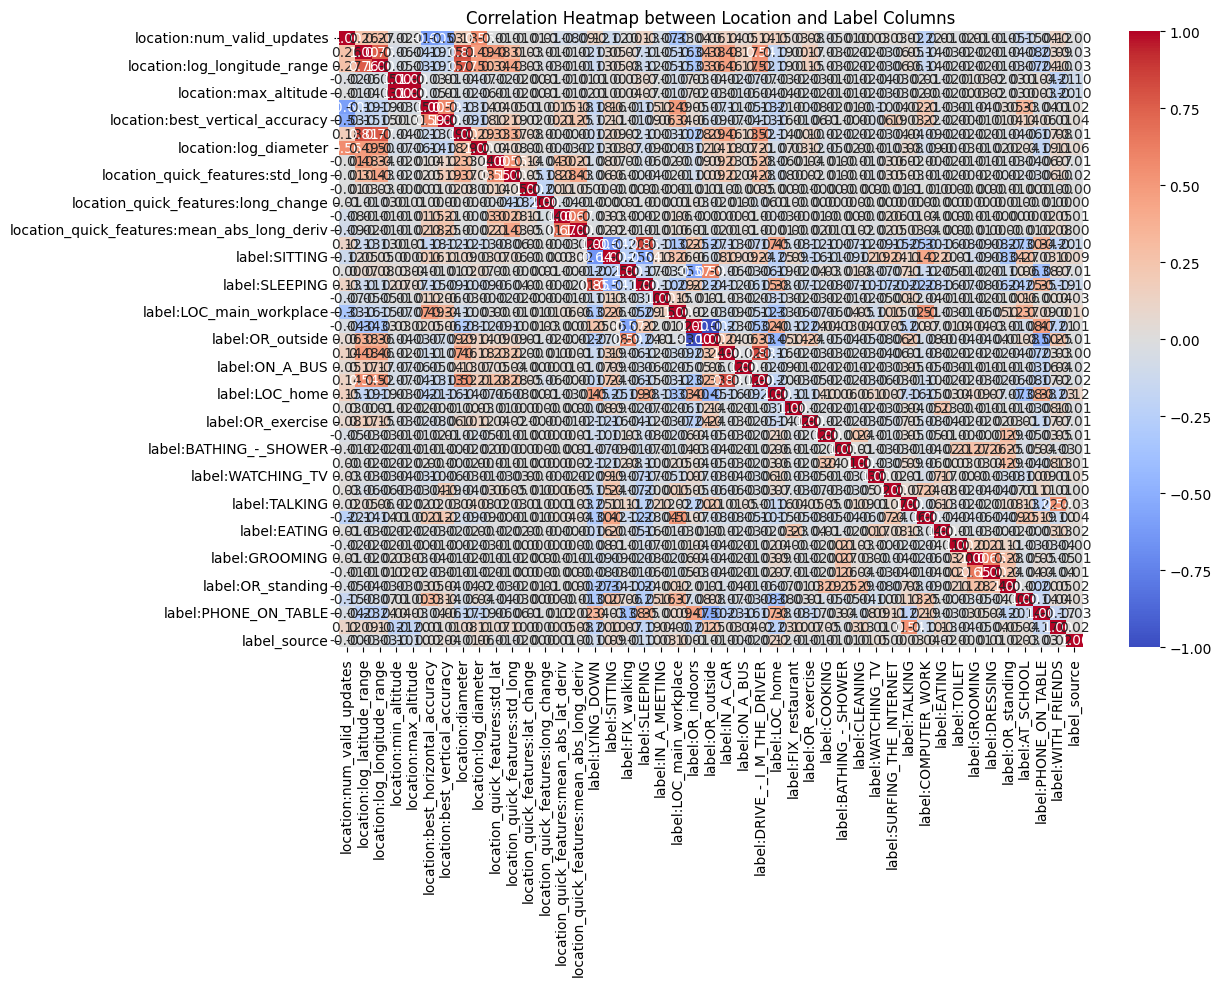

In [16]:
# Select columns starting with 'location' and 'label'
location_columns = df.filter(regex='^location')
label_columns = df.filter(regex='^label')

# Concatenate the selected columns
selected_columns = pd.concat([location_columns, label_columns], axis=1)

# Calculate the correlation matrix
correlation_matrix = selected_columns.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# If you want to visualize the correlation matrix, you can use a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Location and Label Columns')
plt.show()

In [17]:
df = df.drop(columns=location_columns)
df.shape

(377346, 178)

Check if there is correlation between column and label  to predict

In [18]:
df.columns

Index(['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std',
       'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4',
       'raw_acc:magnitude_stats:percentile25',
       'raw_acc:magnitude_stats:percentile50',
       'raw_acc:magnitude_stats:percentile75',
       'raw_acc:magnitude_stats:value_entropy',
       'raw_acc:magnitude_stats:time_entropy',
       'raw_acc:magnitude_spectrum:log_energy_band0',
       ...
       'label:COMPUTER_WORK', 'label:EATING', 'label:TOILET', 'label:GROOMING',
       'label:DRESSING', 'label:OR_standing', 'label:AT_SCHOOL',
       'label:PHONE_ON_TABLE', 'label:WITH_FRIENDS', 'label_source'],
      dtype='object', length=178)

In [19]:
# Select columns that start with "raw", "proc", or "audio"
selected_columns = [col for col in df.columns if col.startswith(("raw", "proc", "audio"))]

# Extract the selected columns and create a new DataFrame
df_selected = df[selected_columns]

# Standardize the selected columns
scaler = StandardScaler()
df_selected_standardized = pd.DataFrame(scaler.fit_transform(df_selected), columns=selected_columns)

# Replace the original columns with the standardized ones in the original DataFrame
df[selected_columns] = df_selected_standardized


BUILD MODEL

In [20]:
y = df.filter(regex='^label:')
x = df.drop(columns= y)

#Replace missing by 0
y.fillna(0, inplace=True)
x.fillna(0, inplace=True)


X_encoded = pd.get_dummies(x)
y_encoded = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(X_encoded.values, y_encoded.values, test_size=0.2, random_state=42)

<ipython-input-20-d11d074a7a0c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.fillna(0, inplace=True)


In [21]:
missing_columns = df.columns[df.isnull().any()]
missing_values = df[missing_columns].isnull().sum()

print("Columns with Missing Values:")
print(missing_values)

Columns with Missing Values:
raw_acc:magnitude_stats:mean               290
raw_acc:magnitude_stats:std                290
raw_acc:magnitude_stats:moment3            290
raw_acc:magnitude_stats:moment4            290
raw_acc:magnitude_stats:percentile25       290
                                         ...  
label:DRESSING                          169438
label:OR_standing                        70752
label:AT_SCHOOL                         118182
label:PHONE_ON_TABLE                    214923
label:WITH_FRIENDS                      211932
Length: 143, dtype: int64


In [22]:
print(X_train)

[[-0.10100567 -0.38597635 -0.32688637 ...  1.          1.
   2.        ]
 [-0.05241402 -0.328781   -0.19556792 ...  0.          0.
  -1.        ]
 [-0.01226218 -0.38319826 -0.3411534  ...  0.          1.
   2.        ]
 ...
 [-0.36425959 -0.38518558 -0.32541109 ...  1.          1.
  -1.        ]
 [-0.0109309  -0.38532085 -0.32867086 ...  0.          1.
   4.        ]
 [ 0.60061545  0.35499321  0.44160705 ...  1.          0.
  -1.        ]]


In [23]:
# Define the classifier (Random Forest in this case)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a MultiOutputClassifier
multi_output_classifier = MultiOutputClassifier(classifier, n_jobs=-1)

# Fit the model
multi_output_classifier.fit(X_train, y_train)



MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42),
                      n_jobs=-1)

CHECK RESULTS


In [24]:
# Make predictions
y_pred = multi_output_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     20925
           1       0.90      0.91      0.90     27081
           2       0.84      0.44      0.58      4425
           3       0.99      0.94      0.97     16670
           4       0.99      0.54      0.70      1048
           5       0.98      0.82      0.90      6714
           6       0.96      0.94      0.95     37008
           7       0.93      0.41      0.57      2430
           8       0.96      0.41      0.57      1169
           9       1.00      0.11      0.19       362
          10       0.96      0.50      0.66      1612
          11       0.95      0.92      0.94     30696
          12       0.99      0.37      0.54       422
          13       0.98      0.58      0.73      1614
          14       1.00      0.28      0.44       870
          15       0.99      0.38      0.55       408
          16       0.97      0.36      0.52

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
